In [19]:
%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import torch
import torch.nn as nn
from torch_geometric.datasets import KarateClub, TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data
import networkx as nx
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from icecream import ic

In [15]:
device = "mps" if torch.backends.mps.is_available() else "cpu"

In [ ]:
from torch_geometric.datasets import KarateClub


## Pytorch geometric introduction

![](../resources/image.png)

In [17]:
edge_index = torch.tensor([[0, 1, 1, 2], [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous())

for key, item in data:
    print(f"{key} found in data")

data.to(device)

x found in data
edge_index found in data


Data(x=[3, 1], edge_index=[4, 2])

In [19]:
ic(data.x)
ic(data.num_edges, data.num_nodes)
ic(data.has_self_loops())
ic(data.is_directed())

ic| data.x: tensor([

[-1.],
                    [ 0.],
                    [ 1.]], device='mps:0')
ic| data.num_edges: 2, data.num_nodes: 3
ic| data.has_self_loops(): False
ic| data.is_directed(): False


False

In [25]:
def plot_graph(G, figsize=(10, 7)):
    plt.figure(figsize=figsize)
    nx.draw(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        cmap="Set2",
    )


In [27]:
tu_ds = TUDataset(root="/tmp/ENZYMES", name="ENZYMES")
tu_ds
tuG = to_networkx(tu_ds[0])

/Users/jkunz/Library/Caches/pypoetry/virtualenvs/cop-gnn-IZjXzcTC-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


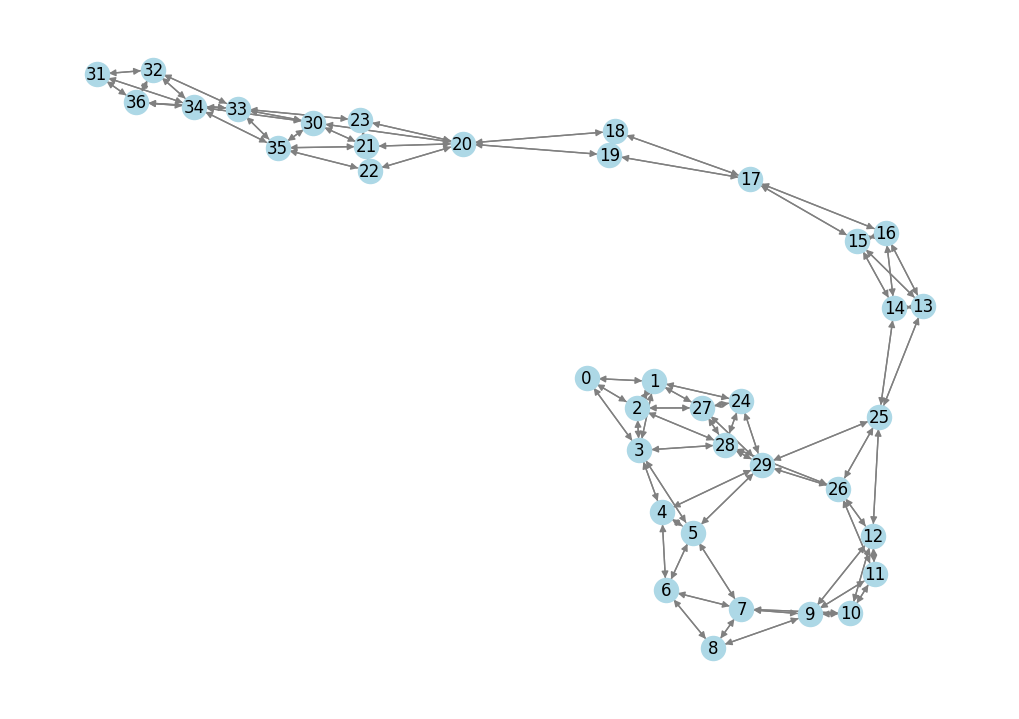

In [28]:
plot_graph(tuG)

/Users/jkunz/Library/Caches/pypoetry/virtualenvs/cop-gnn-IZjXzcTC-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


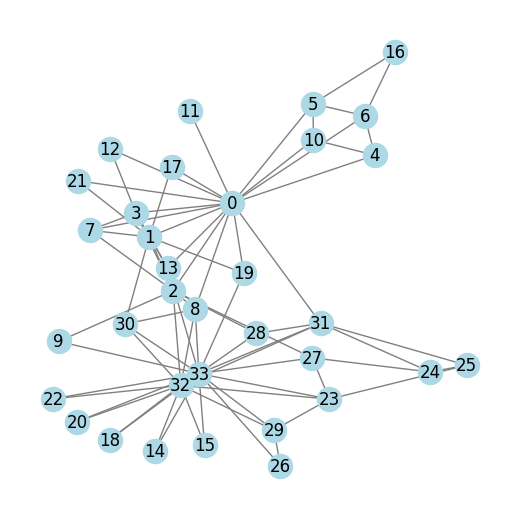

In [ ]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]


G = to_networkx(data, to_undirected=True)
# visualize(G, color=data.y)
# nx.draw(G, with_labels=True)
plot_graph(G, figsize=(5, 5))

In [53]:
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list
labels = data.y.numpy()  # Community labels (0 or 1)

# Construct adjacency matrix (without self-loops for neighborhood computation)
A = torch.zeros((num_nodes, num_nodes))
A[edge_index[0], edge_index[1]] = 1  # Undirected graph

edge_index[0], edge_index[1]
# matrix is symmetric
A[0,] == A[:, 0]


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

In [44]:
i = 0
j = 1
neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
neighbors_i
A[0].nonzero(as_tuple=True)[0]

tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31])

In [45]:
# Compute Jaccard similarity matrix
def compute_jaccard_similarity(A):
    S = torch.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(i, num_nodes):  # Symmetric matrix, compute upper triangle
            neighbors_i = set(A[i].nonzero(as_tuple=True)[0].tolist())
            neighbors_j = set(A[j].nonzero(as_tuple=True)[0].tolist())
            intersection = len(neighbors_i & neighbors_j)
            union = len(neighbors_i | neighbors_j)
            if union > 0:  # Avoid division by zero
                sim = intersection / union
                S[i, j] = sim
                S[j, i] = sim  # Symmetry
    # No self-loops in Jaccard (typically similarity to self is not 1 unless defined)
    return S


S = compute_jaccard_similarity(A)
print("Jaccard similarity matrix sample:\n", S)  # S[:5, :5])


Jaccard similarity matrix sample:
 tensor([[1.0000, 0.3889, 0.2381,  ..., 0.0000, 0.1200, 0.1379],
        [0.3889, 1.0000, 0.2667,  ..., 0.0714, 0.1053, 0.1304],
        [0.2381, 0.2667, 1.0000,  ..., 0.2308, 0.0476, 0.2857],
        ...,
        [0.0000, 0.0714, 0.2308,  ..., 1.0000, 0.0588, 0.0952],
        [0.1200, 0.1053, 0.0476,  ..., 0.0588, 1.0000, 0.5263],
        [0.1379, 0.1304, 0.2857,  ..., 0.0952, 0.5263, 1.0000]])


In [55]:
# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16
node_ids = torch.arange(num_nodes)
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameter for L2 regularization
lambda_reg = 0.01  # Regularization strength


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    recon_loss = torch.norm(S_hat - S, p="fro") ** 2

    # L2 regularization: lambda * ||Z||^2
    l2_reg = lambda_reg * torch.norm(Z, p="fro") ** 2

    loss = recon_loss + l2_reg

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(800):
    loss = train()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    Z_np = Z.numpy()
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 23481.7441
Epoch 100, Loss: 1778.5509
Epoch 200, Loss: 478.2845
Epoch 300, Loss: 191.7710
Epoch 400, Loss: 94.7375
Epoch 500, Loss: 53.7093
Epoch 600, Loss: 33.5836
Epoch 700, Loss: 22.5794
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[-0.0957,  0.1491, -0.0651,  0.0296, -0.0841, -0.1176, -0.0481, -0.1396,
         -0.3829, -0.3897, -0.0452,  0.0627,  0.3738, -0.0275,  0.8148, -0.0448],
        [-0.0211,  0.2932, -0.9189,  0.6767, -0.0353, -0.1574,  0.0423,  0.0150,
         -0.0912, -0.2818, -0.4547, -0.0168,  0.0875,  0.1022,  0.0192,  0.0533],
        [-0.0677, -0.0326, -0.0201,  0.1073,  0.1318, -0.2663, -0.2072, -0.4454,
         -0.1944, -0.0385, -0.3877,  0.1931,  0.1140,  0.2340,  0.1028, -0.4894],
        [-0.1376,  0.0763, -0.0845,  0.0841,  0.4867, -0.1019,  0.0624, -0.1059,
         -0.7226,  0.0812, -0.1198,  0.1987,  0.0715,  0.2931,  0.0524,  0.0145],
        [-0.0249,  0.0419, -0.1060, -0.1427, -0.0459,  0.6161,  0.4838,  0.245

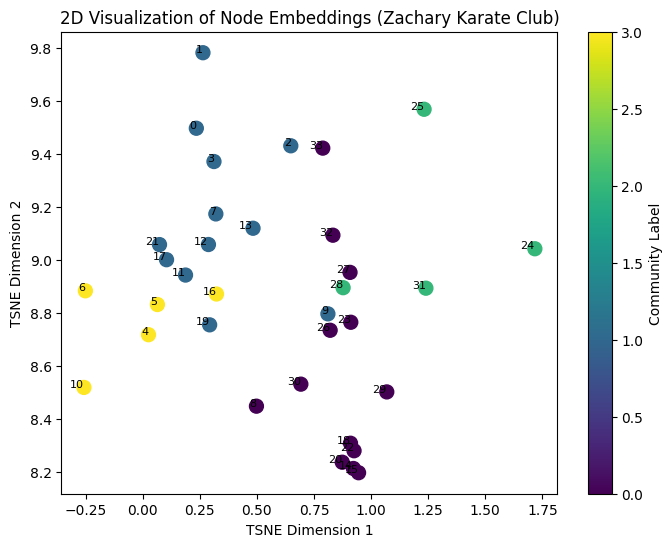

In [56]:
# Reduce embeddings to 2D using TSNE
Z_2d = TSNE(n_components=2, random_state=42).fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club)")
plt.xlabel("TSNE Dimension 1")
plt.ylabel("TSNE Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

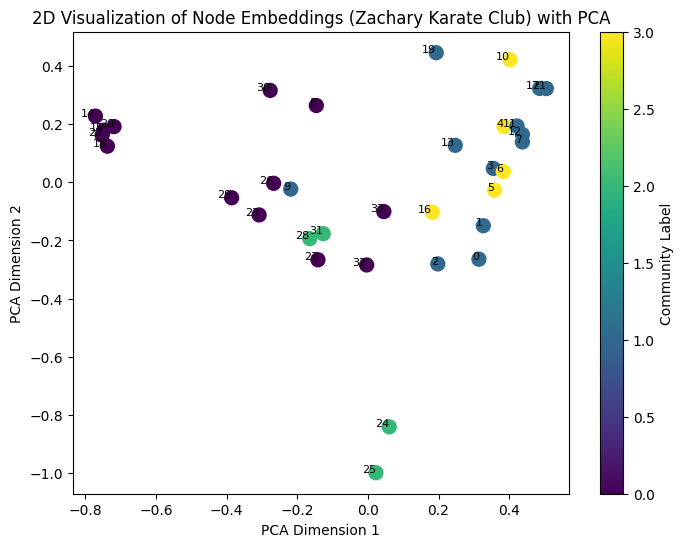

In [58]:
pca = PCA(n_components=2)
Z_2d = pca.fit_transform(Z_np)

# Visualize in 2D
plt.figure(figsize=(8, 6))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, cmap="viridis", s=100)
plt.colorbar(scatter, label="Community Label")
plt.title("2D Visualization of Node Embeddings (Zachary Karate Club) with PCA")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
for i in range(num_nodes):  # Optional: label nodes
    plt.text(Z_2d[i, 0], Z_2d[i, 1], str(i), fontsize=8, ha="right")
plt.show()

In [17]:
# Load the Zachary Karate Club dataset
dataset = KarateClub()
data = dataset[0]  # Single graph
num_nodes = data.num_nodes  # 34 nodes
edge_index = data.edge_index  # Edge list

# Construct the similarity matrix S (adjacency matrix)
S = torch.zeros((num_nodes, num_nodes))
S[edge_index[0], edge_index[1]] = 1  # Undirected graph
S = S + torch.eye(num_nodes)  # Add self-loops (optional)


# Define the model with embedding lookup
class EmbeddingFactorization(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(EmbeddingFactorization, self).__init__()
        # Embedding layer: each node gets a unique embedding
        self.embedding = nn.Embedding(num_nodes, embedding_dim)

    def forward(self, node_ids):
        # Lookup embeddings for all nodes
        Z = self.embedding(node_ids)
        return Z


# Set up model and optimizer
embedding_dim = 16  # Embedding dimension
node_ids = torch.arange(num_nodes)  # Node indices [0, 1, ..., 33]
model = EmbeddingFactorization(num_nodes=num_nodes, embedding_dim=embedding_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training function
def train():
    model.train()
    optimizer.zero_grad()

    # Get embeddings
    Z = model(node_ids)

    # Reconstructed similarity: Z Z^T
    S_hat = torch.matmul(Z, Z.t())

    # L2 (Frobenius) loss: ||Z Z^T - S||^2
    loss = torch.norm(S_hat - S, p="fro") ** 2

    # Backprop
    loss.backward()
    optimizer.step()
    return loss.item()


# Train the model
for epoch in range(200):
    loss = train()
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Get final embeddings
with torch.no_grad():
    Z = model(node_ids)
    print("Final embeddings shape:", Z.shape)
    print("Sample embeddings:\n", Z[:5])  # First 5 nodes

# Evaluate reconstruction error
S_hat = torch.matmul(Z, Z.t())
reconstruction_error = torch.norm(S_hat - S, p="fro").item()
print(f"Final reconstruction error: {reconstruction_error:.4f}")

Epoch 0, Loss: 31349.0488
Epoch 20, Loss: 16256.7090
Epoch 40, Loss: 9214.4258
Epoch 60, Loss: 5793.1211
Epoch 80, Loss: 3942.0808
Epoch 100, Loss: 2835.2307
Epoch 120, Loss: 2122.5625
Epoch 140, Loss: 1638.3839
Epoch 160, Loss: 1295.7561
Epoch 180, Loss: 1045.3267
Final embeddings shape: torch.Size([34, 16])
Sample embeddings:
 tensor([[ 1.1891, -0.6554,  0.3150, -0.2120, -0.1353, -0.0973, -0.1627, -0.5603,
         -0.1730,  0.1762,  0.2956, -0.1453,  0.0596, -0.9718,  0.2601, -0.3672],
        [-0.0604,  0.3826,  0.3026, -0.2847,  0.0025, -0.1528, -0.1496,  0.0244,
          0.0748,  0.8480, -0.1727, -0.0335,  0.5312, -0.4492,  0.8381,  0.7463],
        [-0.1293, -0.1207,  1.2876,  0.0579, -0.0902, -0.1808,  0.4375,  1.9356,
         -0.3006,  0.2868, -0.1242,  0.9487, -0.2708, -0.2260,  0.0160,  0.4128],
        [-0.0202, -0.3186, -0.0662, -1.0502, -0.0573, -0.0099, -0.0756, -0.0319,
          0.1766,  0.2578, -0.1232,  0.3660, -0.0986, -0.5536,  0.2396,  0.1637],
        [-0.0092,